In [46]:
import cv2 
import matplotlib.pyplot as plt
import numpy as np
import os
from os import listdir
from os.path import isfile, join
from json import dump
import time
import pandas as pd
%matplotlib inline

In [2]:
def umat_to_mat(obj):
    return cv2.UMat.get(obj)

In [37]:
def get_metrics(path_directory, image_name, descriptor, keypoints_image_kernel, descriptors_image_kernel, matcher, ratio=0.75):
    
    image_path = f'{path_directory}/{image_name}'
    
    print(image_path)
    metrics = {'ratio':ratio}
    
    # define start time
    time_start = time.thread_time()
    
    image = cv2.imread(image_path)
    metrics['pixels'] = image.shape[0] * image.shape[1]
    image = cv2.UMat(image)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    keypoints_image, descriptors_image = descriptor.detectAndCompute(gray,None)
    
    # find matches
    matches = matcher.knnMatch(descriptors_image_kernel, descriptors_image, k=2) # sift k = 2
    
    # define end time
    time_end = time.thread_time()
    metrics['thread_time'] = time_end - time_start
    
    # compute distance
    good_matches = []
    for m, n in matches:
        if m.distance < ratio * n.distance:
            good_matches.append(m)
    
    metrics['matches_good_ratio'] = len(good_matches) / np.array(matches)[:,1].shape[0]
    
    localization_errors_l1 = np.array([abs(m.distance - n.distance) for m, n in matches])
    localization_errors_l2 = np.array([np.power(m.distance - n.distance, 2) for m, n in matches])
    
    metrics['localization_error_l1_mean'] = localization_errors_l1.mean()
    metrics['localization_error_l2_mean'] = localization_errors_l2.mean()

    
    #-- Localize the object
    obj = np.empty((len(good_matches),2), dtype=np.float32)
    scene = np.empty((len(good_matches),2), dtype=np.float32)

    for i in range(len(good_matches)):
        #-- Get the keypoints from the good matches
        obj[i,0] = keypoints_image_kernel[good_matches[i].queryIdx].pt[0]
        obj[i,1] = keypoints_image_kernel[good_matches[i].queryIdx].pt[1]
        scene[i,0] = keypoints_image[good_matches[i].trainIdx].pt[0]
        scene[i,1] = keypoints_image[good_matches[i].trainIdx].pt[1]
    
    H, _ =  cv2.findHomography(obj, scene, cv2.RANSAC)
    
    metrics['loc_error_norm_of_homography_matrix'] = np.linalg.norm(H)
    
    return metrics

In [42]:
def define_metrics(descriptor_name, directory_train_name, json_dump_name, ratio=0.75, saved_dump=True):
    '''
    descriptor_name - SIFT, AKAZE string format,
    directory_train_name - string format name of directory,
    json_dump_name - string format name of json_dump
    '''
    metrics_images = {}

    
    path_directory = os.path.abspath(os.getcwd())
    path_directory_image = f'{path_directory}/{directory_train_name}'
    
    all_training_set = np.array([f for f in listdir(path_directory_image) if isfile(join(path_directory_image, f))])
    all_training_set = np.sort(all_training_set)
    
    path_kernel_image = f'{path_directory_image}/{all_training_set[0]}'
    
    image_kernel = cv2.imread(path_kernel_image) 
    
    # Turn on GPU
    image_kernel = cv2.UMat(image_kernel)
    
    gray_image_kernel = cv2.cvtColor(image_kernel, cv2.COLOR_BGR2GRAY)
    
    
    
    if descriptor_name == 'sift':
        print('sift')
        descriptor = cv2.xfeatures2d.SIFT_create()
        matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
        
    elif descriptor_name == 'akaze':
        print('akaze')
        descriptor = cv2.AKAZE_create()
        matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_BRUTEFORCE_HAMMING)

    else:
        pass
    
    keypoints_image_kernel, descriptors_image_kernel = descriptor.detectAndCompute(gray_image_kernel,None)
    
    for image_file_name in all_training_set[1:]:

        metrics = get_metrics(path_directory_image, image_file_name, descriptor, keypoints_image_kernel, descriptors_image_kernel, matcher, ratio)
        metrics_images[image_file_name] = metrics
    
    if saved_dump:
        with open(f'{json_dump_name}.json', 'w') as f:
            dump(metrics_images, f, indent=4)
    
    return metrics_images

In [120]:
descriptor_name='sift'
directory_train_name='train_image'
json_dump_name='eiffel'

define_metrics(descriptor_name, directory_train_name, json_dump_name)

sift
/home/eduard/gitRepo/object_recognition/Lab2/train_image/train_2.jpg
/home/eduard/gitRepo/object_recognition/Lab2/train_image/train_3.jpg
/home/eduard/gitRepo/object_recognition/Lab2/train_image/train_4.jpg
/home/eduard/gitRepo/object_recognition/Lab2/train_image/train_5.jpg


{'train_2.jpg': {'ratio': 0.75,
  'pixels': 6016000,
  'thread_time': 4.348215057000004,
  'matches_good_ratio': 0.004919723492028097,
  'localization_error_l1_mean': 12.289054500470527,
  'localization_error_l2_mean': 302.2123734754128,
  'loc_error_norm_of_homography_matrix': 2300.6299602905597},
 'train_3.jpg': {'ratio': 0.75,
  'pixels': 1689600,
  'thread_time': 1.1063516820000103,
  'matches_good_ratio': 0.009992752815252536,
  'localization_error_l1_mean': 14.039985614844237,
  'localization_error_l2_mean': 418.4186197103274,
  'loc_error_norm_of_homography_matrix': 710.8939954280316},
 'train_4.jpg': {'ratio': 0.75,
  'pixels': 298820,
  'thread_time': 0.24630567000001236,
  'matches_good_ratio': 0.003958077823614673,
  'localization_error_l1_mean': 15.267432412517444,
  'localization_error_l2_mean': 454.16609261278154,
  'loc_error_norm_of_homography_matrix': 24.841221620378914},
 'train_5.jpg': {'ratio': 0.75,
  'pixels': 471447,
  'thread_time': 0.36679137700001263,
  'match

In [121]:
descriptor_name='akaze'
directory_train_name='train_image'
json_dump_name='eiffel_akaze'

define_metrics(descriptor_name, directory_train_name, json_dump_name)

akaze
/home/eduard/gitRepo/object_recognition/Lab2/train_image/train_2.jpg
/home/eduard/gitRepo/object_recognition/Lab2/train_image/train_3.jpg
/home/eduard/gitRepo/object_recognition/Lab2/train_image/train_4.jpg
/home/eduard/gitRepo/object_recognition/Lab2/train_image/train_5.jpg


{'train_2.jpg': {'ratio': 0.75,
  'pixels': 6016000,
  'thread_time': 2.8040812599999896,
  'matches_good_ratio': 0.007232546459065796,
  'localization_error_l1_mean': 5.547195714046543,
  'localization_error_l2_mean': 60.43278084714549,
  'loc_error_norm_of_homography_matrix': 2687.915785834188},
 'train_3.jpg': {'ratio': 0.75,
  'pixels': 1689600,
  'thread_time': 0.6163975979999918,
  'matches_good_ratio': 0.014799933031977231,
  'localization_error_l1_mean': 6.627925665494726,
  'localization_error_l2_mean': 92.49439142809308,
  'loc_error_norm_of_homography_matrix': 728.8387020823884},
 'train_4.jpg': {'ratio': 0.75,
  'pixels': 298820,
  'thread_time': 0.15738800799999808,
  'matches_good_ratio': 0.004989117696300017,
  'localization_error_l1_mean': 7.000100452034154,
  'localization_error_l2_mean': 91.05548300686422,
  'loc_error_norm_of_homography_matrix': 547.8982883279839},
 'train_5.jpg': {'ratio': 0.75,
  'pixels': 471447,
  'thread_time': 0.17002884800000118,
  'matches_go

# Working with metrics

In [62]:
file_name_json_sift = 'eiffel.json'
file_name_json_akaze = 'eiffel_akaze.json'
metrices_sift = pd.read_json(file_name_json_sift)
metrices_akaze = pd.read_json(file_name_json_akaze)

metrices_sift = metrices_sift.T
metrices_akaze = metrices_akaze.T

In [63]:
metrices_sift

,ratio,pixels,thread_time,matches_good_ratio,localization_error_l1_mean,localization_error_l2_mean,loc_error_norm_of_homography_matrix
train_2.jpg,0.75,6016000.0,4.470381,0.004920,12.289055,302.212373,2300.629960
train_3.jpg,0.75,1689600.0,1.100838,0.009993,14.039986,418.418620,710.893995
train_4.jpg,0.75,298820.0,0.275489,0.003958,15.267432,454.166093,24.841222
train_5.jpg,0.75,471447.0,0.288205,0.004070,15.324373,449.880986,586.736810


In [64]:
metrices_akaze

,ratio,pixels,thread_time,matches_good_ratio,localization_error_l1_mean,localization_error_l2_mean,loc_error_norm_of_homography_matrix
train_2.jpg,0.75,6016000.0,2.881529,0.007233,5.547196,60.432781,2687.915786
train_3.jpg,0.75,1689600.0,0.654526,0.014800,6.627926,92.494391,728.838702
train_4.jpg,0.75,298820.0,0.153896,0.004989,7.000100,91.055483,547.898288
train_5.jpg,0.75,471447.0,0.192513,0.005190,7.103867,93.620727,511.727894


## Plots

- **red** collor - SIFT 
- **blue** collor - AKAZE

In [100]:
def create_curves_for_tabel(feature_1, feature_2, metrices_sift, metrices_akaze):
    plt.plot(metrices_sift[feature_1], metrices_sift[feature_2], '-', color='red', label='SIFT')
    plt.plot(metrices_akaze[feature_1], metrices_akaze[feature_2], '-', color='blue', label='AKAZE')
    plt.xlabel(feature_1)
    plt.ylabel(feature_2)
    plt.grid(True)
    plt.title(f'{feature_1} - {feature_2}')
    plt.show()
    plt.close()

In [113]:
def create_curves_vectors(feature_1, feature_2, x_label, y_label_swift, y_label_akaze):
    plt.plot(x_label, y_label_swift, '-', color='red', label='sift')
    plt.plot(x_label, y_label_akaze, '-', color='blue', label='akaze')
    plt.xlabel(feature_1)
    plt.ylabel(feature_2)
    plt.grid(True)
    plt.title(f'{feature_1} - {feature_2}')
        
    plt.show()
    plt.close()

### Pixels - time
- **red** collor - SIFT 
- **blue** collor - AKAZE

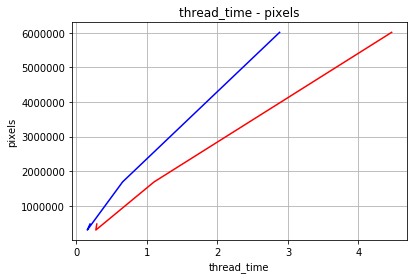

In [118]:
feature_1 = 'thread_time'
feature_2 = 'pixels'
create_curves_for_tabel(feature_1, feature_2, metrices_sift, metrices_akaze)

### Picture - matches_good_ratio
- **red** collor - SIFT 
- **blue** collor - AKAZE

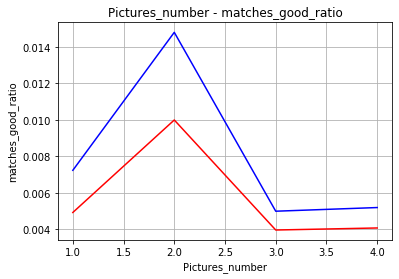

In [114]:
x_label = [x for x in range(1,metrices_sift.shape[0] + 1)]

y_label_swift = metrices_sift['matches_good_ratio']
y_label_akaze = metrices_akaze['matches_good_ratio']

feature_1 = 'Pictures_number'
feature_2 = 'matches_good_ratio'

create_curves_vectors(feature_1, feature_2, x_label, y_label_swift, y_label_akaze)

### Picture - thread_time
- **red** collor - SIFT 
- **blue** collor - AKAZE

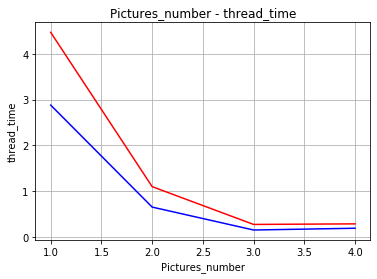

In [115]:
x_label = [x for x in range(1,metrices_sift.shape[0] + 1)]

y_label_swift = metrices_sift['thread_time']
y_label_akaze = metrices_akaze['thread_time']

feature_1 = 'Pictures_number'
feature_2 = 'thread_time'

create_curves_vectors(feature_1, feature_2, x_label, y_label_swift, y_label_akaze)

### Picture - localization_error_l1_mean
- **red** collor - SIFT 
- **blue** collor - AKAZE

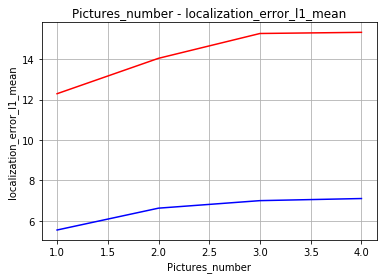

In [116]:
x_label = [x for x in range(1,metrices_sift.shape[0] + 1)]

y_label_swift = metrices_sift['localization_error_l1_mean']
y_label_akaze = metrices_akaze['localization_error_l1_mean']

feature_1 = 'Pictures_number'
feature_2 = 'localization_error_l1_mean'

create_curves_vectors(feature_1, feature_2, x_label, y_label_swift, y_label_akaze)

### Picture - localization_error_l2_mean
- **red** collor - SIFT 
- **blue** collor - AKAZE

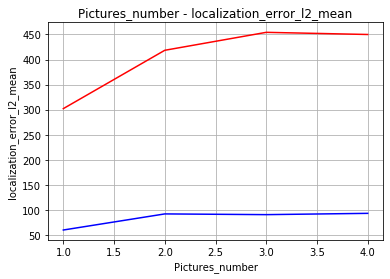

In [117]:
x_label = [x for x in range(1,metrices_sift.shape[0] + 1)]

y_label_swift = metrices_sift['localization_error_l2_mean']
y_label_akaze = metrices_akaze['localization_error_l2_mean']

feature_1 = 'Pictures_number'
feature_2 = 'localization_error_l2_mean'

create_curves_vectors(feature_1, feature_2, x_label, y_label_swift, y_label_akaze)

### Picture - loc_error_norm_of_homography_matrix
- **red** collor - SIFT 
- **blue** collor - AKAZE

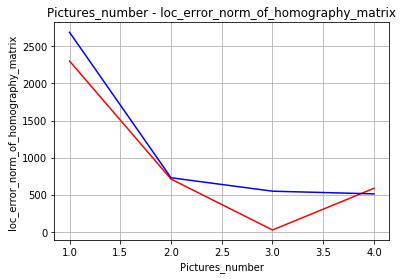

In [119]:
x_label = [x for x in range(1,metrices_sift.shape[0] + 1)]

y_label_swift = metrices_sift['loc_error_norm_of_homography_matrix']
y_label_akaze = metrices_akaze['loc_error_norm_of_homography_matrix']

feature_1 = 'Pictures_number'
feature_2 = 'loc_error_norm_of_homography_matrix'

create_curves_vectors(feature_1, feature_2, x_label, y_label_swift, y_label_akaze)